In [1]:
!python -V

Python 3.11.3


In [1]:
import pandas as pd
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [10]:
df = pd.read_parquet('../data/yellow_tripdata_2022-01.parquet')

df.head(10)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.00,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.00,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.00,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.00,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.00,0.3,30.30,2.5,0.0
5,1,2022-01-01 00:40:15,2022-01-01 01:09:48,1.0,10.30,1.0,N,138,161,1,33.0,3.0,0.5,13.00,6.55,0.3,56.35,2.5,0.0
6,2,2022-01-01 00:20:50,2022-01-01 00:34:58,1.0,5.07,1.0,N,233,87,1,17.0,0.5,0.5,5.20,0.00,0.3,26.00,2.5,0.0
7,2,2022-01-01 00:13:04,2022-01-01 00:22:45,1.0,2.02,1.0,N,238,152,2,9.0,0.5,0.5,0.00,0.00,0.3,12.80,2.5,0.0
8,2,2022-01-01 00:30:02,2022-01-01 00:44:49,1.0,2.71,1.0,N,166,236,1,12.0,0.5,0.5,2.25,0.00,0.3,18.05,2.5,0.0
9,2,2022-01-01 00:48:52,2022-01-01 00:53:28,1.0,0.78,1.0,N,236,141,2,5.0,0.5,0.5,0.00,0.00,0.3,8.80,2.5,0.0


The Dataset has 1.369.769 rows of data, and 19 column features.

In [8]:
df.shape

(2463931, 19)

In [11]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

std = df.duration.std()
print("Standard Deviation of the trips duration in January is " + str(std))

fraction_wo_outliers = ((df.duration >= 1) & (df.duration <= 60)).mean()
print("Fraction of records left after dropping outliers is " + str(fraction_wo_outliers))

# Duration that is at least 1 minute trip and less than 60 minutes trip
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# Convert it into string so one hot encoding works with it.
df[categorical] = df[categorical].astype(str)

Standard Deviation of the trips duration in January is 46.44530513776802
Fraction of records left after dropping outliers is 0.9827547930522406


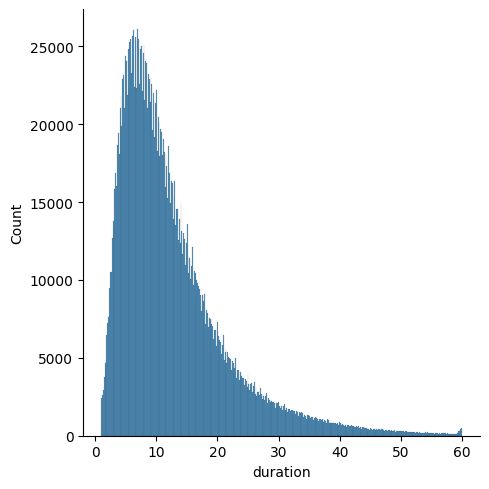

In [5]:
sns.displot(df.duration)

In [6]:
df.duration.describe(percentiles=[0.95,0.98,0.99])

count    2.421440e+06
mean     1.267128e+01
std      8.999282e+00
min      1.000000e+00
50%      1.023333e+01
95%      3.105000e+01
98%      3.971667e+01
99%      4.568333e+01
max      6.000000e+01
Name: duration, dtype: float64

In [13]:
#Training data will contain only the desired column values
# Turn the dataframe into a list of dictionaries
train_dicts = df[categorical + numerical].to_dict(orient='records')

# Turn the list of dictionaries into vectors
dv = DictVectorizer()
# Fit the dictionary vectorizer
X_train = dv.fit_transform(train_dicts)

# Minus 1 beacuse there is a numerical feature
print("Dimensions of One-Hot Encoding features: " + str(len(dv.feature_names_)-1))

# Obtain the ground truth labels
target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

# Compute Root Mean Square error on training
rsme_train = mean_squared_error(y_train, y_pred, squared=False)
print("Training Root Mean Squared Error: " + str(rsme_train))

Dimensions of One-Hot Encoding features: 515
Training Root Mean Squared Error: 7.00149617936508


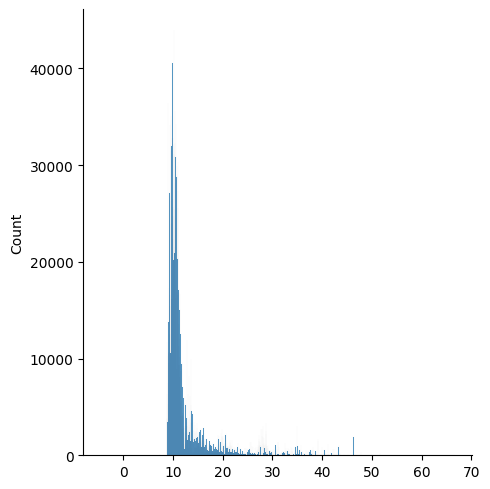

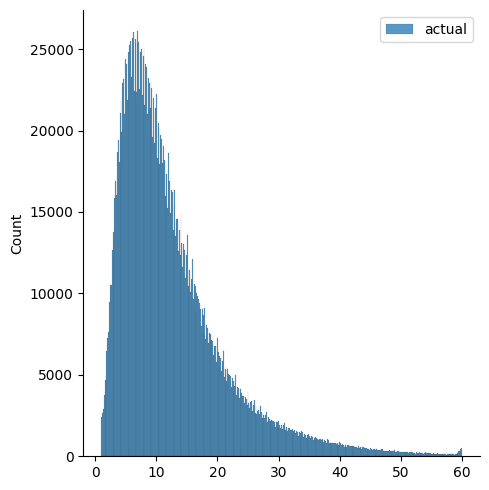

In [15]:
sns.displot(y_pred, label='prediction')
sns.displot(y_train, label='actual')

plt.legend()

Using functions to clean the code and reuse the code.

In [16]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [17]:
df_train = read_dataframe('../data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('../data/yellow_tripdata_2022-02.parquet')

In [18]:
len(df_train), len(df_val)

(2421440, 2918187)

In [19]:
# Interaction features, there are better interpreted together.
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [20]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

# One Hot encoding of categorical features
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [21]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

Train and evaluate the model

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict the values for validation data
y_pred = lr.predict(X_val)

# Root Mean Squared Error on validation
rmse_val = mean_squared_error(y_val, y_pred, squared=False)
print("Validation Root Mean Squared Error: " + str(rmse_val))

Validation Root Mean Squared Error: 5.530272758582475


Export the model as a pickle file

In [ ]:
# wb = Write Binary
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [23]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.374921127169834